# Cell type classification

Variables that will be used to classify the neurons are: 

1. mean firing rate of neurons 
2. spike time autocorrelation of each neuron
3. mean wavefrom of each neuron with the largest amplitude 


The results are saved in `myProject.dataPath+"/results/cell_classification.csv"`

In [17]:
%reload_ext autoreload
%autoreload 2
%run setup_project.py

Project name: autopi_ca1
dataPath: /adata/projects/autopi_ca1
dlcModelPath: /adata/models
Reading /adata/projects/autopi_ca1/sessionList
We have 39 testing sessions in the list
See myProject and sSesList objects


In [18]:
load_spike_train_project(sSesList)

100%|███████████████████████████████████████████| 39/39 [00:07<00:00,  5.57it/s]


## Load waveforms

In [19]:
fn=myProject.dataPath+"/results/mean_waveforms.npy"
wf= np.load(fn)
fn=myProject.dataPath+"/results/ci.scv"
ci= pd.read_csv(fn)
if wf.shape[0] != ci.shape[0]:
    print("Problem with the length of the datasets")
else:
    print("Datasets match: {} neurons".format(wf.shape[0]))

Datasets match: 1268 neurons


In [20]:
ci

,id,subject,session
0,mn5824-20112020-0107_80,mn5824,mn5824-20112020-0107
1,mn5824-20112020-0107_90,mn5824,mn5824-20112020-0107
2,mn5824-20112020-0107_92,mn5824,mn5824-20112020-0107
3,mn5824-20112020-0107_96,mn5824,mn5824-20112020-0107
4,mn5824-20112020-0107_98,mn5824,mn5824-20112020-0107
...,...,...,...
1263,mn9686-01112021-0106_238,mn9686,mn9686-01112021-0106
1264,mn9686-01112021-0106_240,mn9686,mn9686-01112021-0106
1265,mn9686-01112021-0106_241,mn9686,mn9686-01112021-0106
1266,mn9686-01112021-0106_242,mn9686,mn9686-01112021-0106


## Shank location for each neuron

We only want to classify neurons from the pyramidal cell layer.

In [21]:
fn = myProject.dataPath+"/results/shank_neuron.csv"
shanks = pd.read_csv(fn)
if shanks.shape[0] != ci.shape[0]:
    print("Problem with the length of the datasets")
else:
    print("Datasets match: {} neurons".format(wf.shape[0]))
    
      
isPyramidalCellLayer = shanks.layer=="pyr"

Datasets match: 1268 neurons


## Mean firing rates

In [22]:
def get_mean_rate(ses):
    ''' This is a function to get the df containing cell id and mean firing rate'''
    meanRates=[n.spike_train.mean_firing_rate() for n in ses.cg.neuron_list]
    cellID= [ses.name + "_"+ n.name for n in ses.cg.neuron_list]
    df= pd.DataFrame({"cellID": cellID, "meanRate": meanRates}) 
    return df

In [23]:
rate = [ get_mean_rate(ses) for ses in sSesList]
rate = pd.concat(rate,axis=0)
rate.to_csv('/adata/projects/autopi_ca1/results/mean_rate.csv')

In [24]:
if wf.shape[0] != rate.shape[0]:
    print("Problem with the length of the datasets")
else:
    print("Datasets match")

Datasets match


## Spike-time autocorrelations

In [25]:
def get_spike_time_auto(ses):
    """
    Function that returns the spike-time autocorrelation
    """
    for n in ses.cg.neuron_list:
        n.spike_train.spike_time_autocorrelation(bin_size_sec=0.0005, min_sec=0, max_sec=0.05) 

    # get a list of 1D np.array and normalize it to the max value 
    autocorr= [n.spike_train.st_autocorrelation_histogram[0]/np.max(n.spike_train.st_autocorrelation_histogram[0]) for n in ses.cg.neuron_list]
    # add 1D array on top of each other, becomes a 2D array
    autocorr = np.stack(autocorr)
    return autocorr

def get_number_spikes_in_auto(ses):
    """
    Function that returns the spike-time autocorrelation
    """
    for n in ses.cg.neuron_list:
        n.spike_train.spike_time_autocorrelation(bin_size_sec=0.0005, min_sec=0, max_sec=0.05) 
    # get a list of number of spikes in the spike time autocorrelation
    n_spikes= [n.spike_train.st_autocorrelation_histogram[0].sum() for n in ses.cg.neuron_list]
    return np.array(n_spikes)

def get_refractory_ratio(ses):
    ratio= [n.spike_train.refractory_period_ratio() for n in ses.cg.neuron_list]
    return np.array(ratio)

In [26]:
myList = [ get_spike_time_auto(ses) for ses in sSesList ]
auto = np.concatenate(myList)

/tmp/ipykernel_218723/3293564265.py:9: RuntimeWarning: invalid value encountered in true_divide
  autocorr= [n.spike_train.st_autocorrelation_histogram[0]/np.max(n.spike_train.st_autocorrelation_histogram[0]) for n in ses.cg.neuron_list]


In [27]:
n_spikes = [ get_number_spikes_in_auto(ses) for ses in sSesList ]
n_spikes = np.concatenate(n_spikes)
ref = [ get_refractory_ratio(ses) for ses in sSesList ]
ref = np.concatenate(ref)

In [28]:
if wf.shape[0] != ref.shape[0]:
    print("Problem with the length of the datasets")
else:
    print("Datasets match")

Datasets match


## Remove outliers or dirty clusters or cortical neurons

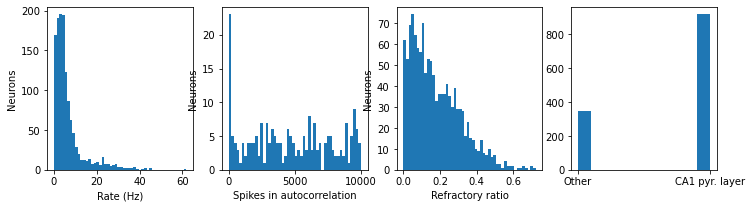

In [29]:
fig,axes = plt.subplots(1,4,figsize=(12,3))

axes[0].hist(rate.meanRate,bins=50)
axes[0].set_xlabel("Rate (Hz)")
axes[0].set_ylabel("Neurons")

axes[1].hist(n_spikes[n_spikes<10000],bins=50)
axes[1].set_xlabel("Spikes in autocorrelation")
axes[1].set_ylabel("Neurons")

axes[2].hist(ref[ref<1],bins=50)
axes[2].set_xlabel("Refractory ratio")
axes[2].set_ylabel("Neurons")


axes[3].hist(isPyramidalCellLayer.to_numpy().astype(int))
axes[3].set_xticks([0,1])
axes[3].set_xticklabels(["Other","CA1 pyr. layer"])
plt.show()



In [30]:
valid_rate = (rate.meanRate<100).to_numpy() # incredible high rate
valid_n_spikes = n_spikes>100 # not enough spikes in spike-time autocorrelation
valid_refractory = ref < 0.25
valid = np.logical_and(valid_rate,valid_n_spikes)
valid = np.logical_and(valid,valid_refractory)
valid = np.logical_and(valid,isPyramidalCellLayer)
print(valid_rate.shape,valid_n_spikes.shape,valid_refractory.shape,isPyramidalCellLayer.shape,valid.shape)
print(valid_rate.sum(),valid_n_spikes.sum(),valid_refractory.sum(),isPyramidalCellLayer.sum(),valid.sum())

(1268,) (1268,) (1268,) (1268,) (1268,)
1268 1246 897 918 626


In [31]:
from sklearn.decomposition import PCA
pca_wf=PCA(svd_solver='full') # keep all the component at the first 
pca_wf= pca_wf.fit(wf[valid])
comp_wf= pca_wf.components_
compVariation_wf= pca_wf.explained_variance_ratio_
corrcoef_comp_wf= np.corrcoef(comp_wf)
print(comp_wf.shape)



(60, 60)


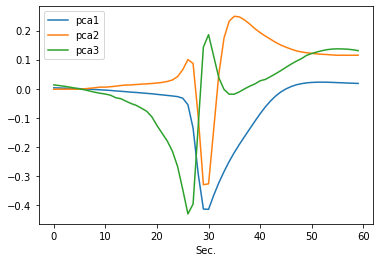

In [32]:
plt.plot(comp_wf[0,:],label='pca1')
plt.plot(comp_wf[1,:], label= 'pca2') 
plt.plot(comp_wf[2,:],label= 'pca3')
plt.xlabel("Sec.")
plt.legend()
plt.show()

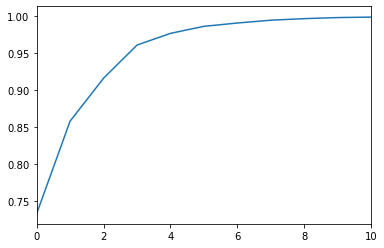

In [33]:
plt.plot(np.cumsum(compVariation_wf))
plt.xlim(0, 10)
plt.show()

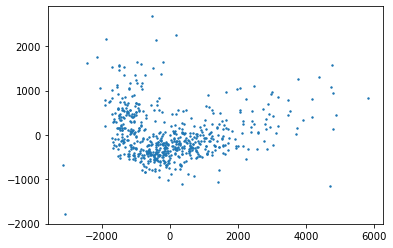

In [34]:
X_wf = pca_wf.transform(wf)
plt.scatter(X_wf[valid,0],X_wf[valid,1],s=2)

In [35]:
pca_auto=PCA(svd_solver='full') # keep all the component at the first 
pca_auto= pca_auto.fit(auto[valid])
comp_auto= pca_auto.components_
compVariation_auto= pca_auto.explained_variance_ratio_
corrcoef_comp_auto= np.corrcoef(comp_auto)
print(comp_auto.shape)

(100, 100)


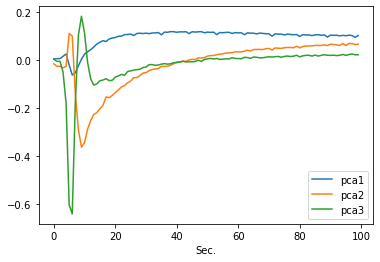

In [36]:
plt.plot(comp_auto[0,:],label='pca1')
plt.plot(comp_auto[1,:], label= 'pca2') 
plt.plot(comp_auto[2,:],label= 'pca3')
plt.xlabel("Sec.")
plt.legend()
plt.show()

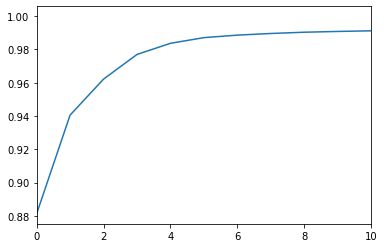

In [37]:
plt.plot(np.cumsum(compVariation_auto))
plt.xlim(0, 10)
plt.show()

(1268, 100)


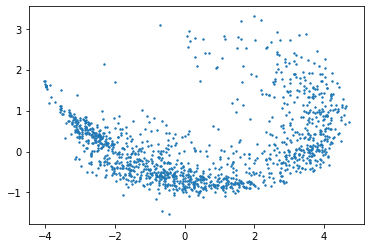

In [38]:
auto[np.isnan(auto)] = 0
X_auto = pca_auto.transform(auto)
print(X_auto.shape)
plt.scatter(X_auto[:,0],X_auto[:,1],s=2)

## Create a dataset to train our classifer

This dataset only contains neurons from the pyramidal cell layer of the hippocampus.

In [39]:
print(np.expand_dims(rate.meanRate.to_numpy(),1)[valid].shape, X_wf[valid,0:3].shape, X_auto[valid,0:3].shape)  
myList = [np.expand_dims(rate.meanRate.to_numpy(),1)[valid],
         X_wf[valid,0:3],
         X_auto[valid,0:3]]
X = np.concatenate(myList,axis=1)
X.shape

(626, 1) (626, 3) (626, 3)


(626, 7)

## Scale features

In [40]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X)
print(scaler.mean_,scaler.scale_)
X_scaled = scaler.transform(X)
print(X_scaled.mean(axis=0),X_scaled.std(axis=0))
print(X_scaled.shape)

[ 7.01915775e+00  6.97376129e-14  2.71776921e-13  2.70766725e-13
  2.67446697e-16 -3.29519869e-16 -1.24057669e-16] [8.55536784e+00 1.33025382e+03 5.51036848e+02 3.75008301e+02
 2.53893578e+00 6.59193519e-01 3.98267047e-01]
[-1.97703054e-16 -1.52167948e-16 -4.82397225e-17  1.15589114e-16
 -3.95672135e-16 -1.31506449e-16  3.83434853e-16] [1. 1. 1. 1. 1. 1. 1.]
(626, 7)


# Classification of neurons

In [41]:
from sklearn.cluster import KMeans
kmeans_classifier = KMeans(n_clusters=2, random_state=0) ## to get the first two pca
kmeans_classifier.fit(X_scaled)
y= kmeans_classifier.predict(X_scaled)
y = y.astype(int)
print(np.sum(y==1),np.sum(y==0))

188 438


Identify which label is which using firing rate. Rates should be higher for interneurons.

In [42]:
if X[y==0,0].mean() > X[y==1,0].mean():
    myLab=["Interneurons","Pyramidal cells"]
    myCode=np.array(["int","pyr"])
    myCol=np.array(["blue","red"])
else:
    myLab=["Pyramidal cells","Interneurons"]
    myCol=np.array(["red","blue"])
    myCode=np.array(["pyr","int"])
    

In [43]:
# mean rate in numpy array
mr = rate.meanRate.to_numpy()[valid]

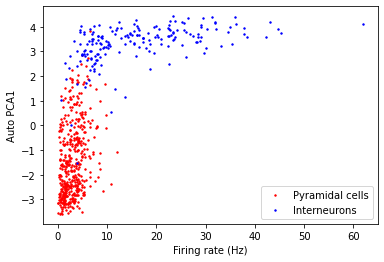

In [44]:
plt.scatter(mr[y==0], X_auto[valid][y==0,0],c=myCol[0],s=2)
plt.scatter(mr[y==1], X_auto[valid][y==1,0],c=myCol[1],s=2)
plt.xlabel("Firing rate (Hz)")
plt.ylabel("Auto PCA1")
plt.legend(labels=myLab)
plt.show()

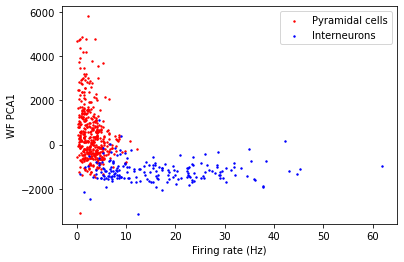

In [45]:
plt.scatter(mr[y==0], X_wf[valid][y==0,0],c=myCol[0],s=2)
plt.scatter(mr[y==1], X_wf[valid][y==1,0],c=myCol[1],s=2)
plt.xlabel("Firing rate (Hz)")
plt.ylabel("WF PCA1")
plt.legend(labels=myLab)
plt.show()

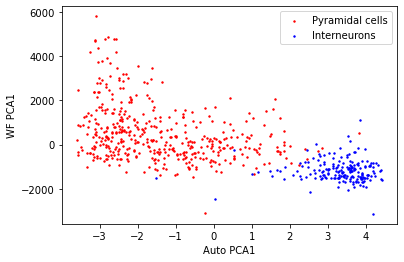

In [46]:
plt.scatter(X_auto[valid][y==0,0], X_wf[valid,0][y==0],c=myCol[0],s=2)
plt.scatter(X_auto[valid][y==1,0], X_wf[valid,0][y==1],c=myCol[1],s=2)
plt.xlabel("Auto PCA1")
plt.ylabel("WF PCA1")
plt.legend(labels=myLab)
plt.show()

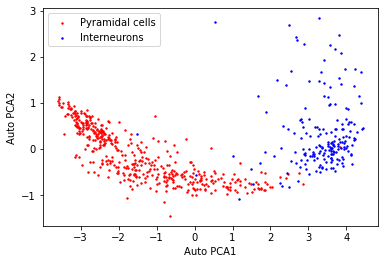

In [47]:
plt.scatter(X_auto[valid][y==0,0], X_auto[valid][y==0,1],c=myCol[0],s=2)
plt.scatter(X_auto[valid][y==1,0], X_auto[valid][y==1,1],c=myCol[1],s=2)
plt.legend(labels=myLab)
plt.xlabel("Auto PCA1")
plt.ylabel("Auto PCA2")
plt.show()

## Mean spike-time autocorrelation of pyramidal cells and interneurons

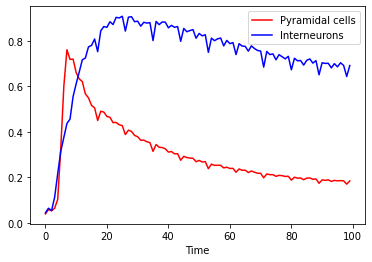

In [48]:
plt.plot(auto[valid][y==0].mean(axis=0),c=myCol[0])
plt.plot(auto[valid][y==1].mean(axis=0),c=myCol[1])
plt.xlabel("Time")
plt.legend(labels=myLab)
plt.show()

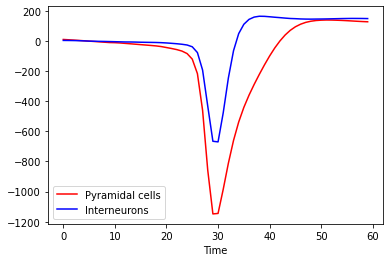

In [49]:
plt.plot(wf[valid][y==0].mean(axis=0),c=myCol[0])
plt.plot(wf[valid][y==1].mean(axis=0),c=myCol[1])
plt.xlabel("Time")
plt.legend(labels=myLab)
plt.show()

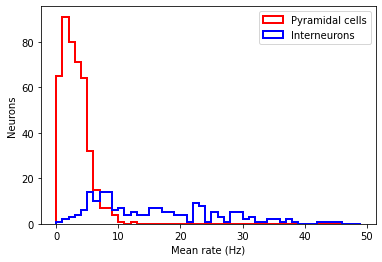

In [50]:
plt.hist(mr[y==0],histtype='step',color=myCol[0],bins=np.arange(0,50,1),linewidth=2)
plt.hist(mr[y==1],histtype='step',color=myCol[1],bins=np.arange(0,50,1),linewidth=2)
plt.xlabel("Mean rate (Hz)")
plt.ylabel("Neurons")
plt.legend(labels=myLab)
plt.show()

## Save the findings for later use

We will create a DataFrame that can be used to identify cells as pyramidal cells and interneurons.

In [51]:
df = pd.DataFrame({"id":ci.id,
                   "session":ci.session,
                   "subject":ci.subject,
                   "valid":valid, 
                   "cellType":np.nan,"meanRate":rate.meanRate.to_numpy()})
df.cellType.loc[valid==True]=myCode[y]
df["shank"]=shanks.shank
df["layer"]=shanks.layer
print(df)
print("df.shape:",df.shape)
print("Pyramidal cells: ",np.sum(df.cellType=="pyr"))
print("Interneurons: ",np.sum(df.cellType=="int"))
print("mean rate int: {:.3f} Hz, pyr: {:.3f} Hz".format(df.meanRate.loc[df.cellType=="int"].mean(),df.meanRate.loc[df.cellType=="pyr"].mean()))

fn=myProject.dataPath+"/results/cell_classification.csv"
print("saving to ", fn)
df.to_csv(fn,index=False)

                            id               session subject  valid cellType  \
0      mn5824-20112020-0107_80  mn5824-20112020-0107  mn5824  False      NaN   
1      mn5824-20112020-0107_90  mn5824-20112020-0107  mn5824  False      NaN   
2      mn5824-20112020-0107_92  mn5824-20112020-0107  mn5824   True      pyr   
3      mn5824-20112020-0107_96  mn5824-20112020-0107  mn5824  False      NaN   
4      mn5824-20112020-0107_98  mn5824-20112020-0107  mn5824  False      NaN   
...                        ...                   ...     ...    ...      ...   
1263  mn9686-01112021-0106_238  mn9686-01112021-0106  mn9686  False      NaN   
1264  mn9686-01112021-0106_240  mn9686-01112021-0106  mn9686  False      NaN   
1265  mn9686-01112021-0106_241  mn9686-01112021-0106  mn9686  False      NaN   
1266  mn9686-01112021-0106_242  mn9686-01112021-0106  mn9686   True      pyr   
1267  mn9686-01112021-0106_246  mn9686-01112021-0106  mn9686   True      pyr   

       meanRate  shank layer  
0      9

## Create a summary figure

Let's first present a first figure of the procedure for clustering.


In [52]:
wf.shape

(1268, 60)

Saving figure in /adata/projects/autopi_ca1/results/classification.svg


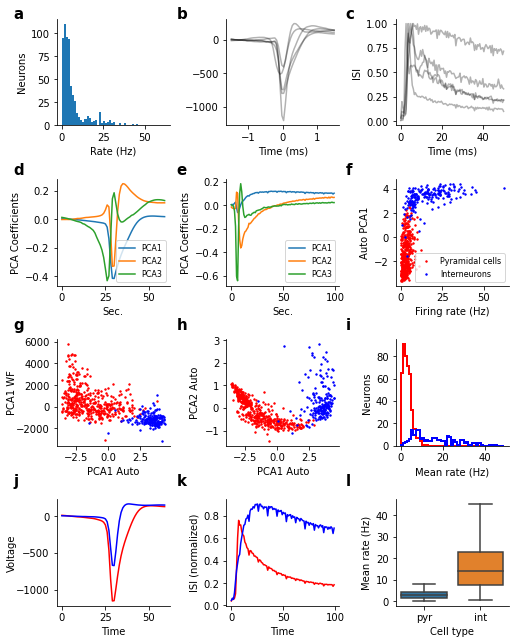

In [53]:
import matplotlib.gridspec as gridspec
import seaborn as sns

col=3
row=4
sizePerCol=2.7
sizePerRow=2.7

if X[y==0,0].mean() > X[y==1,0].mean():
    myLab=["Interneurons","Pyramidal cells"]
    myCode=np.array(["int","pyr"])
    myCol=np.array(["blue","red"])
else:
    myLab=["Pyramidal cells","Interneurons"]
    myCol=np.array(["red","blue"])
    myCode=np.array(["pyr","int"])
    

fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=False) # create the overall figure to put all the axes on


#grid spec object
gs = fig.add_gridspec(nrows=row, ncols=col,wspace=0.5,hspace=0.5)

# distribution of firing rate
ax = fig.add_subplot(gs[0,0])
ax.hist(mr,bins=50)
ax.set_xlabel("Rate (Hz)")
ax.set_ylabel("Neurons")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# example of waveforms
time = np.linspace(-1.5,1.5,wf.shape[1])
ax = fig.add_subplot(gs[0,1])
indices=[10,20,40,50,60]
for i in indices:
    ax.plot(time,wf[valid][i],c="black",alpha=0.3)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Time (ms)")



# exampel of st autocorrelations
# example of waveforms
time = np.linspace(0,50,auto.shape[1])
ax = fig.add_subplot(gs[0,2])
indices=[10,20,40,50,60]
for i in indices:
    ax.plot(time,auto[valid][i],c="black",alpha=0.3)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Time (ms)")
ax.set_ylabel("ISI")


# pca of waveforms
ax = fig.add_subplot(gs[1,0])
ax.plot(comp_wf[0,:], label='PCA1')
ax.plot(pca_wf.components_[1,:], label='PCA2')
ax.plot(pca_wf.components_[2,:], label='PCA3')
ax.set_xlabel("Sec.")
ax.set_ylabel("PCA Coefficients")
ax.legend(prop={'size': 8})
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# pca of autocorrelation
ax = fig.add_subplot(gs[1,1])
ax.plot(comp_auto[0,:], label='PCA1')
ax.plot(pca_auto.components_[1,:], label='PCA2')
ax.plot(pca_auto.components_[2,:], label='PCA3')
ax.set_xlabel("Sec.")
ax.set_ylabel("PCA Coefficients")
ax.legend(prop={'size': 8})
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


## projection 1 with k-means
ax = fig.add_subplot(gs[1,2])
ax.scatter(mr[y==0], X_auto[valid][y==0,0],c=myCol[0],s=2)
ax.scatter(mr[y==1], X_auto[valid][y==1,0],c=myCol[1],s=2)
ax.set_xlabel("Firing rate (Hz)")
ax.set_ylabel("Auto PCA1")
ax.legend(labels=myLab, prop={'size': 8})
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# projection 2 with k-means
ax = fig.add_subplot(gs[2,0])
ax.scatter(X_auto[valid][y==0,0], X_wf[valid,0][y==0],c=myCol[0],s=2)
ax.scatter(X_auto[valid][y==1,0], X_wf[valid,0][y==1],c=myCol[1],s=2)
ax.set_xlabel("PCA1 Auto")
ax.set_ylabel("PCA1 WF")
ax.yaxis.set_label_coords(-0.35, 0.5)
#ax.legend(labels=myLab, prop={'size': 8})
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# projection 3 with k-means
ax = fig.add_subplot(gs[2,1])
ax.scatter(X_auto[valid][y==0,0], X_auto[valid][y==0,1],c=myCol[0],s=2)
ax.scatter(X_auto[valid][y==1,0], X_auto[valid][y==1,1],c=myCol[1],s=2)
ax.set_xlabel("PCA1 Auto")
ax.set_ylabel("PCA2 Auto")
#ax.legend(labels=myLab, prop={'size': 8})
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# mean firing rate of neuron
ax = fig.add_subplot(gs[2,2])
ax.hist(mr[y==0],histtype='step',color=myCol[0],bins=np.arange(0,50,1),linewidth=2)
ax.hist(mr[y==1],histtype='step',color=myCol[1],bins=np.arange(0,50,1),linewidth=2)
ax.set_xlabel("Mean rate (Hz)")
ax.set_ylabel("Neurons")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.legend(labels=myLab,prop={'size': 8})

# mean waveform of neurons
ax = fig.add_subplot(gs[3,0])

ax.plot(wf[valid][y==0].mean(axis=0),c=myCol[0])
ax.plot(wf[valid][y==1].mean(axis=0),c=myCol[1])
ax.set_xlabel("Time")
ax.set_ylabel("Voltage")
ax.yaxis.set_label_coords(-0.35, 0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.legend(labels=myLab,prop={'size': 8})

# mean autocorrelation of neurons
ax = fig.add_subplot(gs[3,1])
ax.plot(auto[valid][y==0].mean(axis=0),c=myCol[0])
ax.plot(auto[valid][y==1].mean(axis=0),c=myCol[1])
ax.set_xlabel("Time")
ax.set_ylabel("ISI (normalized)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.legend(labels=myLab,prop={'size': 8})

ax = fig.add_subplot(gs[3,2])
ax = sns.boxplot(x="cellType", y="meanRate", data=df,showfliers = False)
ax.set_xlabel("Cell type")
ax.set_ylabel("Mean rate (Hz)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.set_ylim(0,40)

plt.text(0.05,0.88, 'a', style='normal',fontsize=15, weight="bold", transform=plt.gcf().transFigure)
plt.text(0.33,0.88, 'b', style='normal',fontsize=15, weight="bold", transform=plt.gcf().transFigure)
plt.text(0.62,0.88, 'c', style='normal',fontsize=15, weight="bold", transform=plt.gcf().transFigure)
plt.text(0.05,0.68, 'd', style='normal',fontsize=15, weight="bold", transform=plt.gcf().transFigure)
plt.text(0.33,0.68, 'e', style='normal',fontsize=15, weight="bold", transform=plt.gcf().transFigure)
plt.text(0.62,0.68, 'f', style='normal',fontsize=15, weight="bold", transform=plt.gcf().transFigure)
plt.text(0.05,0.48, 'g', style='normal',fontsize=15, weight="bold", transform=plt.gcf().transFigure)
plt.text(0.33,0.48, 'h', style='normal',fontsize=15, weight="bold", transform=plt.gcf().transFigure)
plt.text(0.62,0.48, 'i', style='normal',fontsize=15, weight="bold", transform=plt.gcf().transFigure)
plt.text(0.05,0.28, 'j', style='normal',fontsize=15, weight="bold", transform=plt.gcf().transFigure)
plt.text(0.33,0.28, 'k', style='normal',fontsize=15, weight="bold", transform=plt.gcf().transFigure)
plt.text(0.62,0.28, 'l', style='normal',fontsize=15, weight="bold", transform=plt.gcf().transFigure)

fn=myProject.dataPath+"/results/classification.svg"
print("Saving figure in",fn)
plt.savefig(fn)
plt.show()

Figure x: (**a**) Distribution of mean firing rate for all recorded neurons. (**b**) Examples of spike waveforms. (**c**) Examples of spike-time autocorrelations (**d**) Coefficients of the first 3 principal components of a PCA analysis applied to the spike waveforms of the neurons. (**e**) Coefficients of the first 3 principal components of a PCA analysis applied to the spike-time autocorrelation of the neurons. (**f**) Mean firing rate and PCA1 from spike-time autocorrelations for pyramidal cells and interneurons. (**g**) PCA1 from spike-time autocorrelations and spike waveforms. (**h**) PCA1 and PCA2 from spike-time autocorrelations. (**i**) Distribution of mean firing rate of pyramidal cells and interneurons. (**j**) Mean waveforms of pyramidal cells and interneurons. (**k**) Mean spike-time autocorrelation of pyramidal cells and interneurons. (**l**) Mean firing rate of pyramidal cells and interneurons


## Figure on the number of neurons per animal and number of neurons per session

From now on we only include pyramidal cells or interneurons.

In [54]:
import seaborn as sns
dfVal = df[df.valid==True]

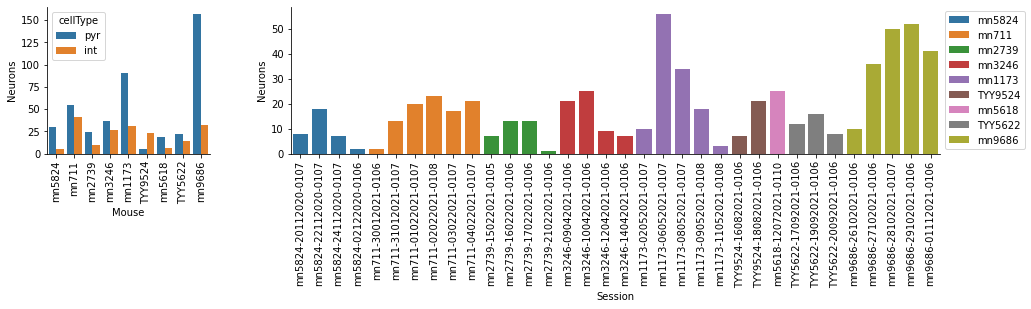

In [55]:
col=4
row=1
sizePerCol=4
sizePerRow=2.7

fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=False) # create the overall figure to put all the axes on
#grid spec object
gs = fig.add_gridspec(nrows=row, ncols=col,wspace=0.5,hspace=0.2)

# distribution of firing rate
ax = fig.add_subplot(gs[0,0])
g = sns.countplot(x="subject", hue="cellType", data=dfVal)
ax.set_ylabel("Neurons")
ax.set_xlabel("Mouse")
ax.set_xticklabels(g.get_xticklabels(), rotation=90)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = fig.add_subplot(gs[0,1:])
g=sns.countplot(x="session",hue="subject",data=dfVal,dodge=False)
ax.set_ylabel("Neurons")
ax.set_xlabel("Session")
ax.set_xticklabels(g.get_xticklabels(), rotation=90)
#ax.set_xticks(rotation=90)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

In [56]:
cnt = dfVal.groupby(["subject","cellType"]).id.count().reset_index()